In [1]:
import pandas as pd

In [2]:
test = pd.read_csv('/Users/t2023-m0149/Documents/spartacodingclub/Projects/4. insurance/test.csv')

In [ ]:
train = pd.read_csv('/Users/t2023-m0149/Documents/spartacodingclub/Projects/4. insurance/sample.csv')

In [35]:
train = pd.read_csv('/Users/t2023-m0149/Documents/spartacodingclub/Projects/4. insurance/train.csv')

# 전처리

In [36]:
df = train.copy()

In [37]:
import numpy as np
import pandas as pd

# ---------------------
# Age - 결측 제거
# ---------------------
df = df.dropna(subset=['Age']) # 결측치 제거


# ---------------------
# gender - 0/1 인코딩
# ---------------------
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})


# ---------------------
# Annual Income - 중앙값 로그변환
# ---------------------
df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())
df['Annual Income'] = np.log1p(df['Annual Income'])  # log(1 + x)


# ---------------------
# Marital Status - 최빈값
# ---------------------
mode = df['Marital Status'].mode()[0]
df['Marital Status'] = df['Marital Status'].fillna(mode)


# ---------------------
# Number of dependents - 삭제
# ---------------------
df = df.dropna(subset=['Number of Dependents'])


# ---------------------
# Education level - 수동인코딩
# ---------------------
edu_map = {
   "High School": 0,
   "Bachelor's": 1,
   "Master's": 2,
   "PhD": 3
}
df["Education Level"] = df["Education Level"].map(edu_map)


# ---------------------
# Health Score
# ---------------------
# 중앙값 계산
median_val = df['Health Score'].median()

# 결측치 대체
df['Health Score'] = df['Health Score'].fillna(median_val)

# 로그 변환 (log(1 + x) 방식으로 음수/0 방지)
df['Health Score_log'] = np.log1p(df['Health Score'])

# 이상치 탐지(IQR 방법)
Q1 = df['Health Score'].quantile(0.25)
Q3 = df['Health Score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# ---------------------
# Location - 원핫 인코딩
# ---------------------
# 원-핫 인코딩 적용 (접두사 prefix를 'Location'으로 지정)
location_dummies = pd.get_dummies(df['Location'], prefix='Location')


# 기존 데이터프레임에 인코딩된 컬럼 추가
df = pd.concat([df, location_dummies], axis=1)
# 필요시 원본 'Location' 컬럼 삭제
df = df.drop(columns=['Location'])


# ---------------------
# Policy Type - 원핫인코딩
# ---------------------
df = pd.get_dummies(df, columns=['Policy Type'])


# ---------------------
# Vehicle Age - 제거
# ---------------------
df = df.dropna(subset=['Vehicle Age']) # 결측치 제거


# ---------------------
# Credit score -
# ---------------------
# 1. 문자열에서 숫자형으로 변환
df['Credit Score'] = pd.to_numeric(df['Credit Score'], errors='coerce')

# 2. 결측치 평균으로 대체
mean_val = df['Credit Score'].mean()
df['Credit Score'] = df['Credit Score'].fillna(mean_val)

# 3. 이상치 탐지 (IQR 방법)
Q1 = df['Credit Score'].quantile(0.25)
Q3 = df['Credit Score'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4-1. 이상치 제거 (선택)
df_iqr_filtered = df[(df['Credit Score'] >= lower_bound) & (df['Credit Score'] <= upper_bound)]


# ---------------------
# Insurance Duration -  1개라서 제거
# ---------------------
df = df.dropna(subset=['Insurance Duration']) # 결측치 제거
# 2. IQR 기준 이상치 탐지 및 클리핑
Q1 = df['Insurance Duration'].quantile(0.25)
Q3 = df['Insurance Duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# ---------------------
# policy start date
# ---------------------
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']) # 날짜형

# 날짜파생변수
df['Start_Year'] = df['Policy Start Date'].dt.year
df['Start_Month'] = df['Policy Start Date'].dt.month
df['Start_Day'] = df['Policy Start Date'].dt.day
df['Start_Weekday'] = df['Policy Start Date'].dt.weekday

# ---------------------
# customer feedback - 결측값 모은 매개 생성
# ---------------------
label_map = {'Poor': 0, 'Average': 1, 'Good': 2}
df = df.dropna(subset=['Customer Feedback'])
df['Customer Feedback'] = df['Customer Feedback'].map(label_map)

# customer_feedback_missing 컬럼 생성 (결측이면 0, 값 있으면 1)
df['customer_feedback_missing'] = df['Customer Feedback'].isna().map({True: 0, False: 1})

# ---------------------
# smoking status
# ---------------------
df['Smoking Status_Num'] = df['Smoking Status'].map({True: 1, False: 0})

# ---------------------
# exercise freq - 운동 하는 사람 / 안 하는 사람으로 먼저 실험
# ---------------------
order_map = {'Rarely': 1, 'Monthly': 2, 'Weekly': 3, 'Daily': 4}
df['Exercise_Freq_Label'] = df['Exercise Frequency'].map(order_map)

# ---------------------
# property type - 원핫인코딩
# ---------------------
prop_dummies = pd.get_dummies(df['Property Type'], prefix='Property')
df = pd.concat([df, prop_dummies], axis=1)

# ---------------------
# previous claims
# ---------------------
# 1) 결측치 0으로 대체
df['Previous Claims'] = df['Previous Claims'].fillna(0)

# 2) 기존 함수 적용
def map_claims_level(x):
   if x == 0:
       return 'Zero'
   elif 1 <= x <= 2:
       return 'Low(1-2)'
   else:
       return 'High(3+)'

df['Previous_Claims_Level'] = df['Previous Claims'].apply(map_claims_level)

# ---------------------
# occupation
# ---------------------
import numpy as np
# 1. 결측치 개수 확인
missing_count = df['Occupation'].isnull().sum()

# 2. 고유값 추출
unique_values = df['Occupation'].dropna().unique()

# 3. 균등하게 샘플 생성
fill_values = np.tile(unique_values, int(np.ceil(missing_count / len(unique_values))))[:missing_count]

# 4. 셔플 (무작위 배치)
np.random.shuffle(fill_values)

# 5. 결측치에 채워넣기
df.loc[df['Occupation'].isnull(), 'Occupation'] = fill_values

In [38]:
df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Previous Claims,...,Start_Month,Start_Day,Start_Weekday,customer_feedback_missing,Smoking Status_Num,Exercise_Freq_Label,Property_Apartment,Property_Condo,Property_House,Previous_Claims_Level
0,0,19.0,0,9.215328,Married,1.0,1,Self-Employed,22.598761,2.0,...,12,23,5,1,NaN,3,False,False,True,Low(1-2)
1,1,39.0,0,10.363409,Divorced,3.0,2,Unemployed,15.569731,1.0,...,6,12,0,1,NaN,2,False,False,True,Low(1-2)
2,2,23.0,1,10.150465,Divorced,3.0,0,Self-Employed,47.177549,1.0,...,9,30,5,1,NaN,3,False,False,True,Low(1-2)
3,3,21.0,1,11.862568,Married,2.0,1,Self-Employed,10.938144,1.0,...,6,12,2,1,NaN,4,True,False,False,Low(1-2)
4,4,21.0,1,10.587897,Single,1.0,1,Self-Employed,20.376094,0.0,...,12,1,2,1,NaN,3,False,False,True,Zero


In [40]:
df.isna().sum()

id                                 0
Age                                0
Gender                             0
Annual Income                      0
Marital Status                     0
Number of Dependents               0
Education Level                    0
Occupation                         0
Health Score                       0
Previous Claims                    0
Vehicle Age                        0
Credit Score                       0
Insurance Duration                 0
Policy Start Date                  0
Customer Feedback                  0
Smoking Status                     0
Exercise Frequency                 0
Property Type                      0
Premium Amount                     0
Health Score_log                   0
Location_Rural                     0
Location_Suburban                  0
Location_Urban                     0
Policy Type_Basic                  0
Policy Type_Comprehensive          0
Policy Type_Premium                0
Start_Year                         0
S

In [41]:
df.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Policy Start Date', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Property Type', 'Premium Amount',
       'Health Score_log', 'Location_Rural', 'Location_Suburban',
       'Location_Urban', 'Policy Type_Basic', 'Policy Type_Comprehensive',
       'Policy Type_Premium', 'Start_Year', 'Start_Month', 'Start_Day',
       'Start_Weekday', 'customer_feedback_missing', 'Smoking Status_Num',
       'Exercise_Freq_Label', 'Property_Apartment', 'Property_Condo',
       'Property_House', 'Previous_Claims_Level'],
      dtype='object')

In [45]:
pip install statsmodels

You should consider upgrading via the '/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# 상관관계 분석

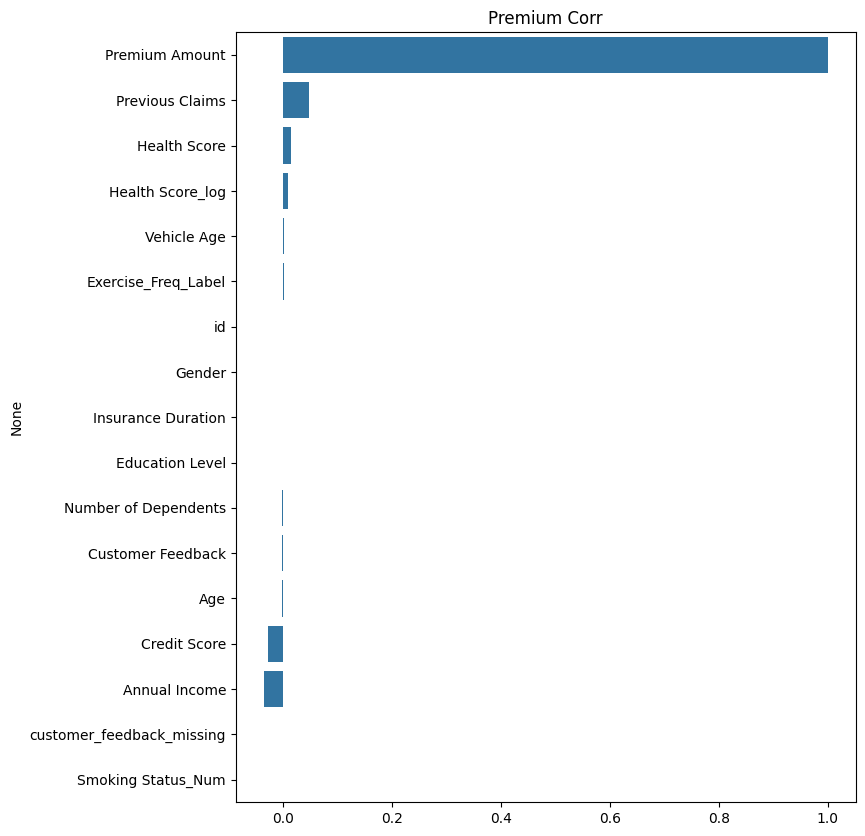

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 컬럼들만
num_cols = df.select_dtypes(include=['float64', 'int64'])

# 타겟과 상관관계
corr_target = num_cols.corr()['Premium Amount'].sort_values(ascending=False)

# 시각화
plt.figure(figsize=(8, 10))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Premium Corr")
plt.show()

### 피어슨 & 스피어만

/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/t2023-m0149/

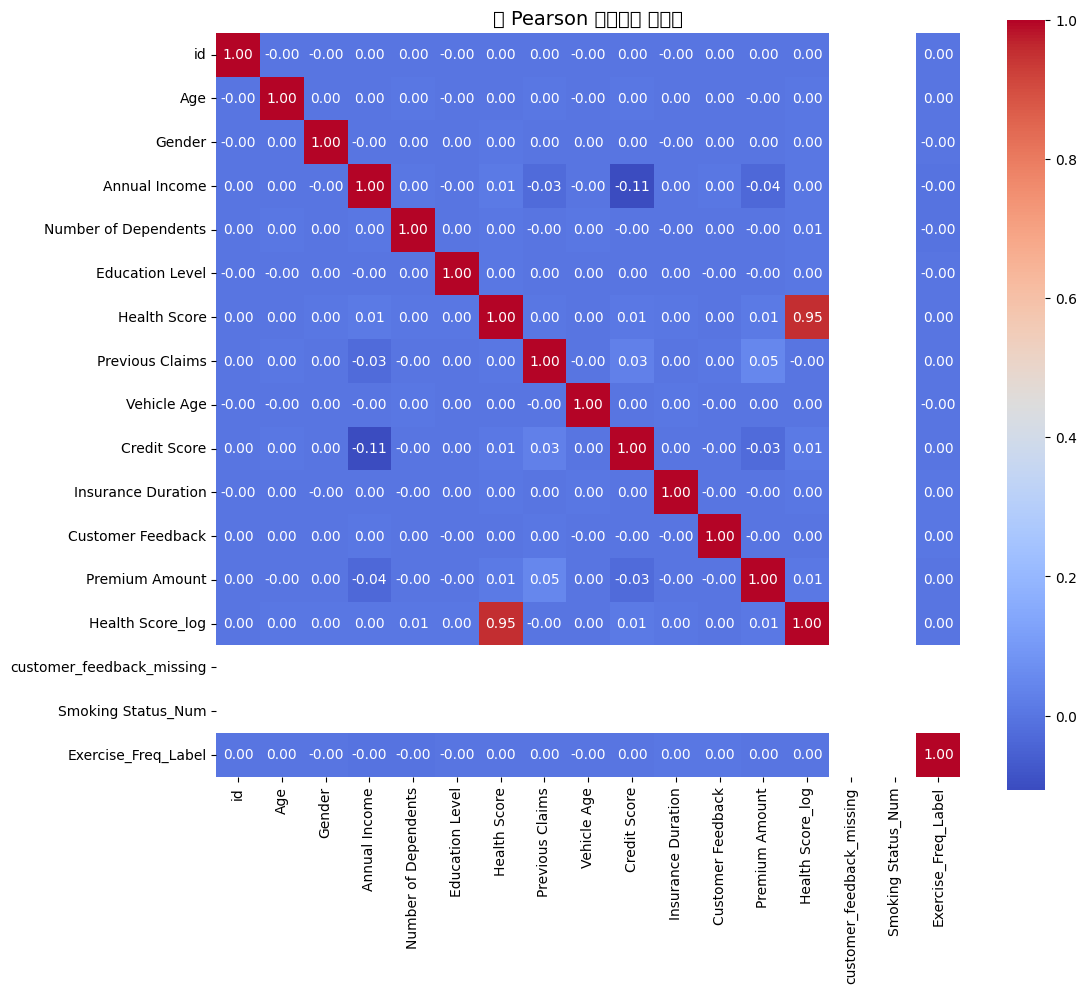

/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Use

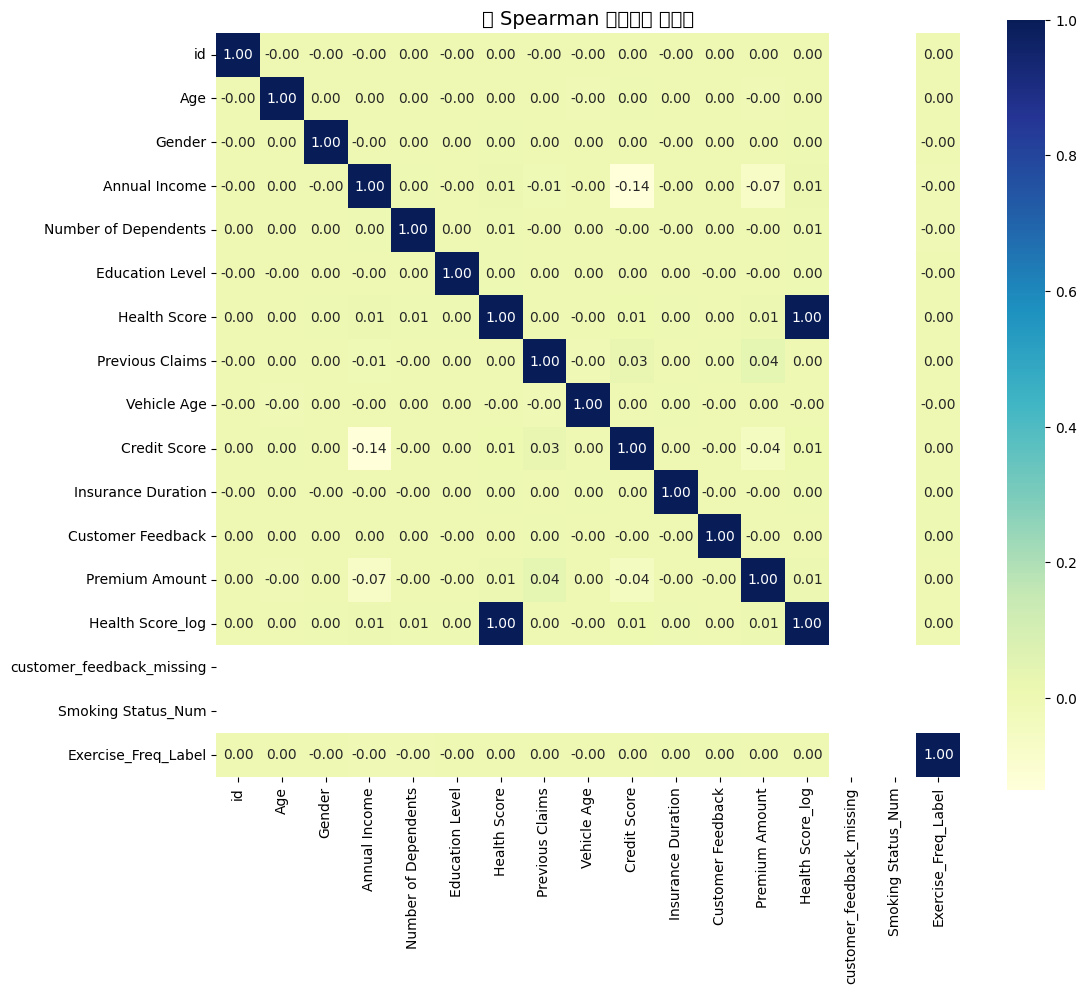

In [50]:
# 1. 피어슨 상관관계 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(num_cols.corr(method='pearson'), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 Pearson 상관계수 히트맵", fontsize=14)
plt.show()

# ---------------------------
# 2. 스피어만 상관관계 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(num_cols.corr(method='spearman'), annot=True, fmt=".2f", cmap='YlGnBu', square=True)
plt.title("📈 Spearman 상관계수 히트맵", fontsize=14)
plt.show()


In [52]:
# Pearson 기준
pearson_corr = num_cols.corr(method='pearson')['Premium Amount'].sort_values(ascending=False)

# Spearman 기준
spearman_corr = num_cols.corr(method='spearman')['Premium Amount'].sort_values(ascending=False)

# 비교 테이블
corr_compare = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})
print(corr_compare)


                            Pearson  Spearman
Age                       -0.002368 -0.002277
Annual Income             -0.035039 -0.067410
Credit Score              -0.027701 -0.044489
Customer Feedback         -0.001241 -0.001334
Education Level           -0.000545 -0.000632
Exercise_Freq_Label        0.000910  0.000960
Gender                     0.000250  0.000021
Health Score               0.014030  0.014950
Health Score_log           0.008945  0.014950
Insurance Duration        -0.000306 -0.000333
Number of Dependents      -0.001233 -0.001856
Premium Amount             1.000000  1.000000
Previous Claims            0.047387  0.040034
Smoking Status_Num              NaN       NaN
Vehicle Age                0.001146  0.001541
customer_feedback_missing       NaN       NaN
id                         0.000311  0.001353


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# 🎯 1. 수치형 변수만 선택 (Premium Amount 제외)
X = df.select_dtypes(include=[np.number]).drop(columns=['Premium Amount'])


# 🎯 2. 결측치 처리 (여기선 0으로 대체하겠슴다)
X = X.fillna(0)


# 🎯 3. 상수항 추가
X_const = add_constant(X)


# 🎯 VIF 계산 (전체 열 인덱스 기준)
vif = pd.DataFrame()
vif["Feature"] = X_const.columns  # const 포함됨
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]


# 🎯 상수항 제외하고 보기
vif = vif[vif["Feature"] != "const"]
vif = vif.sort_values(by="VIF", ascending=False)


print(vif)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

/Users/t2023-m0149/Documents/GitHub/4gun4_new_project/alex/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                      Feature           VIF
17  customer_feedback_missing  2.018707e+06
6                Health Score  1.131347e+01
12           Health Score_log  1.131199e+01
13                 Start_Year  1.073230e+00
14                Start_Month  1.072839e+00
3               Annual Income  1.013050e+00
9                Credit Score  1.012422e+00
7             Previous Claims  1.001605e+00
15                  Start_Day  1.000375e+00
4        Number of Dependents  1.000071e+00
1                         Age  1.000053e+00
10         Insurance Duration  1.000045e+00
19        Exercise_Freq_Label  1.000044e+00
16              Start_Weekday  1.000043e+00
8                 Vehicle Age  1.000041e+00
11          Customer Feedback  1.000039e+00
2                      Gender  1.000025e+00
5             Education Level  1.000023e+00
0                          id  1.000014e+00
18         Smoking Status_Num           NaN


/var/folders/b9/dfc3sg191zvbsylvkl6d4ty40000gn/T/ipykernel_7451/1541868771.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=vif, palette="coolwarm")
/var/folders/b9/dfc3sg191zvbsylvkl6d4ty40000gn/T/ipykernel_7451/1541868771.py:9: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b9/dfc3sg191zvbsylvkl6d4ty40000gn/T/ipykernel_7451/1541868771.py:9: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b9/dfc3sg191zvbsylvkl6d4ty40000gn/T/ipykernel_7451/1541868771.py:9: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b9/dfc3sg191zvbsylvkl6d4ty40000gn/T/ipykernel_7451/1541868771.py:9: UserWarning: Glyph 47749 (

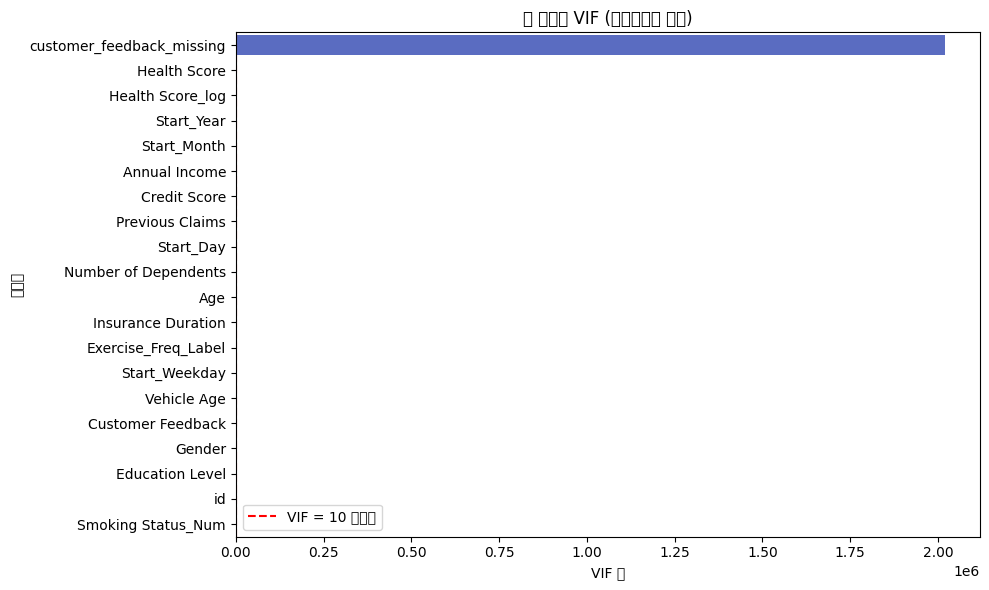

In [59]:
# VIF 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="VIF", y="Feature", data=vif, palette="coolwarm")
plt.title("📊 변수별 VIF (다중공선성 지표)")
plt.xlabel("VIF 값")
plt.ylabel("변수명")
plt.axvline(x=10, color="red", linestyle="--", label="VIF = 10 기준선")
plt.legend()
plt.tight_layout()
plt.show()